In [106]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from torchvision import transforms as T,datasets
import torch.nn.functional as F 
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch import nn
import timm

In [107]:
def show_image(image,label,get_denormalize = True):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)
        
    else: 
        plt.imshow(image)
        plt.title(label)

def show_grid(image,title = None):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    image = image*std + mean
    image = np.clip(image,0,1)
    
    plt.figure(figsize=[15, 15])
    plt.imshow(image)
    if title != None:
        plt.title(title)


def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))


def view_classify(image,ps,label):
    
    class_name = ['NORMAL', 'PNEUMONIA']
    classes = np.array(class_name)

    ps = ps.cpu().data.numpy().squeeze()
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    
    image = image*std + mean
    img = np.clip(image,0,1)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

In [108]:
class CFG:

  epochs =10                              # No. of epochs for training the model
  lr = 0.0001                              # Learning rate
  batch_size = 16                         # Batch Size for Dataset

  model_name = 'tf_efficientnet_b4_ns'    # Model name (we are going to import model from timm)
  img_size = 224                          # Resize all the images to be 224 by 224

  # going to be used for loading dataset
  #Data_DIR = "chest_xray"
  #TEST = "test"
  #TRAIN = "train"
  #VAL = "val"
  train_path='data/train'
  validate_path='data/val'
  test_path='data/test'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("On which device we are on:{}".format(device))


On which device we are on:cuda


In [109]:
train_transform = T.Compose([
                             
                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             T.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

validate_transform = T.Compose([
                             
                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             #T.RandomRotation(degrees=(-20,+20)), #NO need for validation
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

test_transform = T.Compose([
                             
                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             #T.RandomRotation(degrees=(-20,+20)), #NO need for validation
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

In [110]:
trainset=datasets.ImageFolder(CFG.train_path,transform=train_transform)
print("Trainset Size:  {}".format(len(trainset)))

validateset=datasets.ImageFolder(CFG.validate_path,transform=validate_transform)
print("validateset Size:  {}".format(len(validateset)))

testset=datasets.ImageFolder(CFG.test_path,transform=test_transform)
print("testset Size:  {}".format(len(testset)))

Trainset Size:  5216
validateset Size:  16
testset Size:  624


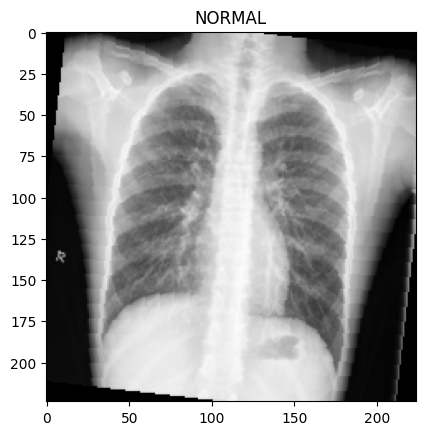

In [111]:
img,label = trainset[1234]
#print(trainset.class_to_idx)

class_name =["NORMAL","PNEUMONIA"]
show_image(img,class_name[label]) 

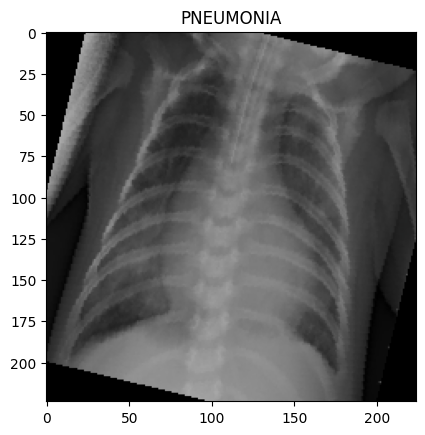

In [112]:
img,label = trainset[3141]
#print(trainset.class_to_idx)

class_name =["NORMAL","PNEUMONIA"]
show_image(img,class_name[label]) 

In [113]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

trainloader = DataLoader(trainset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in trainloader:{}".format(len(trainloader))) #Trainset Size:  5216 / batch_size: 16 = 326(No. of batches in trainloader) 
print("No. of Total examples:{}".format(len(trainloader.dataset)))

validationloader = DataLoader(validateset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in validationloader:{}".format(len(validationloader))) #validationset Size:  16 / batch_size: 16 = 1(No. of batches in validationloader) 
print("No. of Total examples:{}".format(len(validationloader.dataset)))

testloader = DataLoader(testset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in testloader:{}".format(len(testloader))) #testset Size:  624 / batch_size: 16 = 39(No. of batches in testloader) 
print("No. of Total examples:{}".format(len(testloader.dataset)))

No. of batches in trainloader:326
No. of Total examples:5216
No. of batches in validationloader:1
No. of Total examples:16
No. of batches in testloader:39
No. of Total examples:624


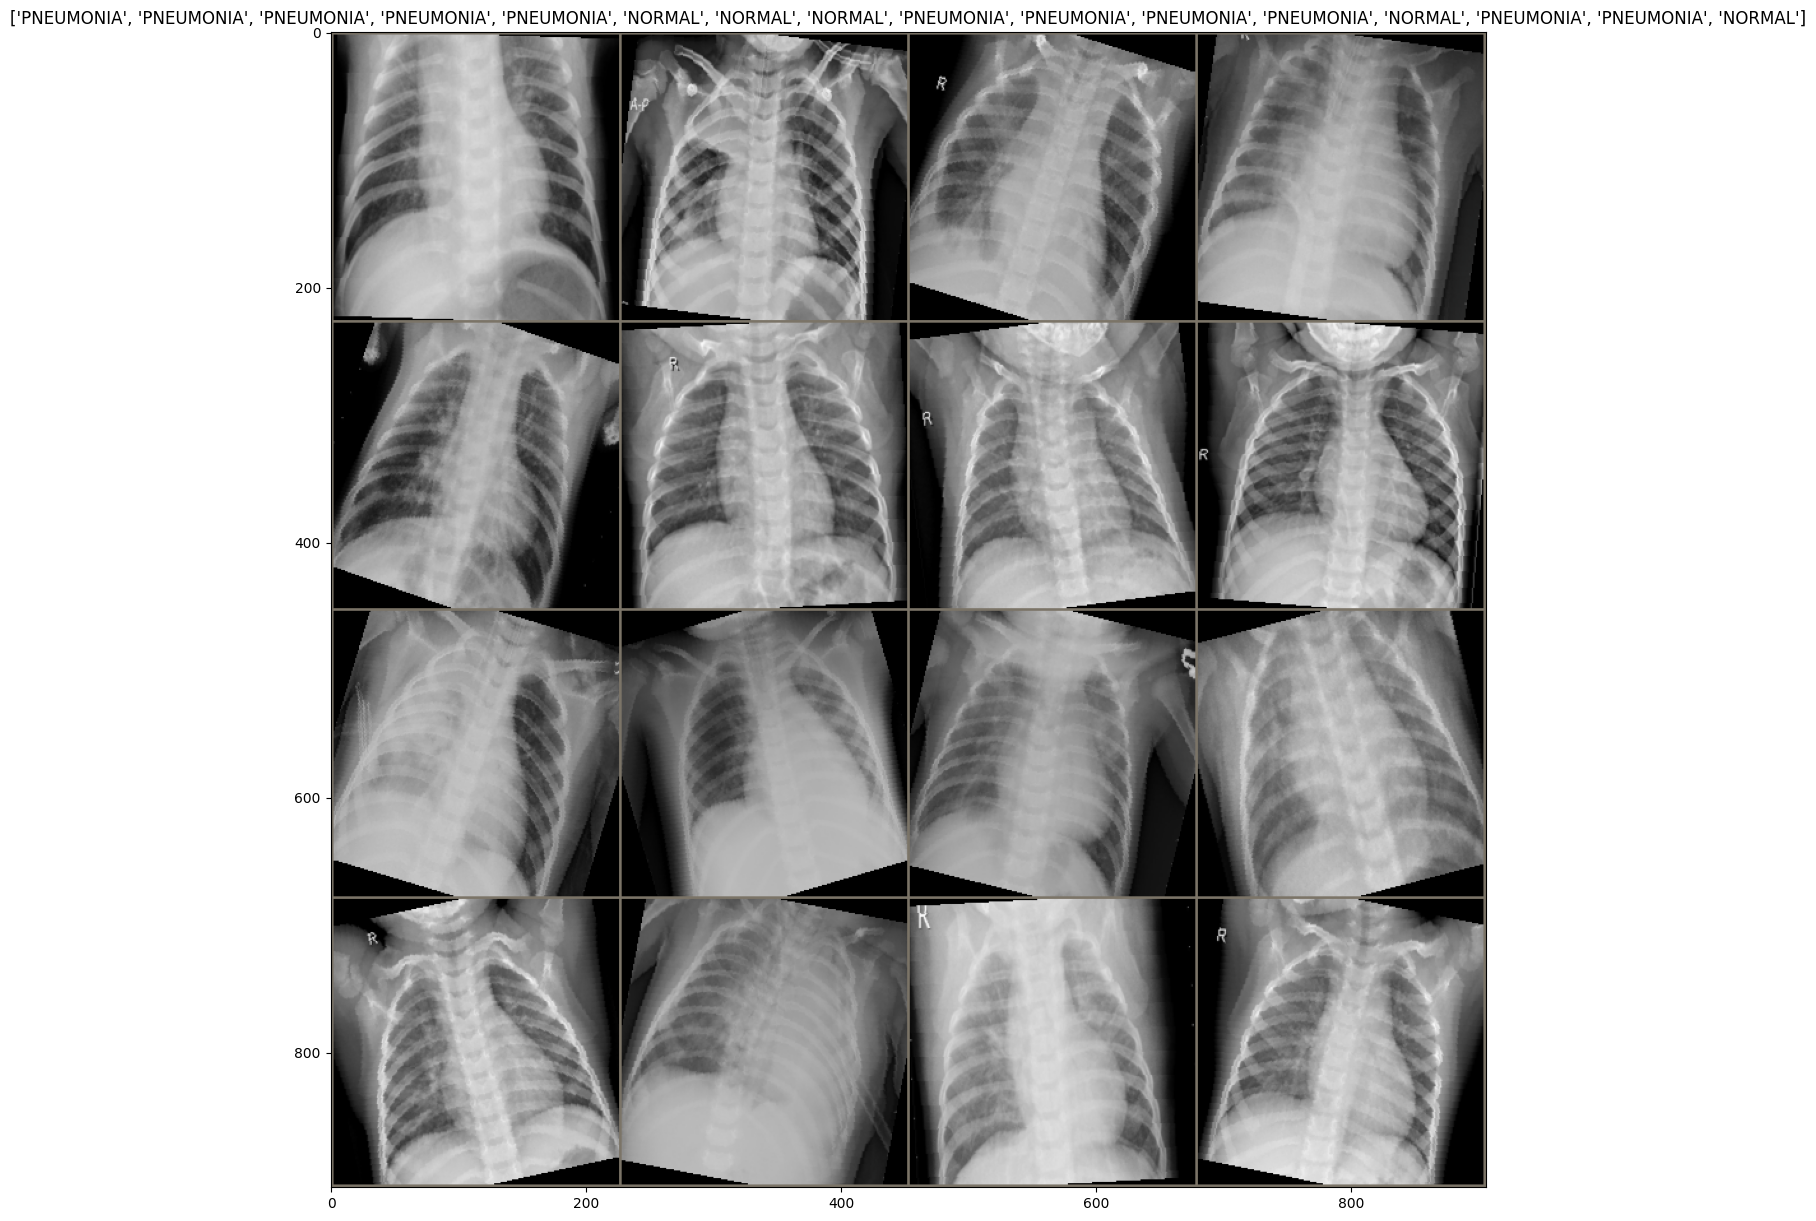

In [114]:
dataiter = iter(trainloader)
images,labels = next(dataiter)

out = make_grid(images,nrow=4)

show_grid(out,title = [class_name[x] for x in labels])

In [115]:
model = timm.create_model(CFG.model_name,pretrained=True)

In [116]:
model

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
     

In [117]:
for param in model.parameters():
  param.requires_grad=False

#orginally, it was:
#(classifier): Linear(in_features=1792, out_features=1000, bias=True)


#we are updating it as a 2-class classifier:
model.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features=625), #1792 is the orginal in_features
    nn.ReLU(), #ReLu to be the activation function
    nn.Dropout(p=0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=2), 
)

model

# after updatingnow it becomes:
#(classifier): Sequential(
#    (0): Linear(in_features=1792, out_features=625, bias=True)
#    (1): ReLU()
#    (2): Dropout(p=0.3, inplace=False)
#    (3): Linear(in_features=625, out_features=256, bias=True)
#    (4): ReLU()
#    (5): Linear(in_features=256, out_features=2, bias=True)
#  )

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
     

In [118]:
model.to(device) # move the model to GPU

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
     

In [119]:
class PneumoniaTrainer():
    
    def __init__(self,criterion = None,optimizer = None,schedular = None):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
    
    def train_batch_loop(self,model,trainloader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(trainloader): 
            
            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(logits,labels)
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self,model,validloader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(validloader):
            
            # move the data to CPU
            images = images.to(device) 
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(logits,labels)
            
        return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self,model,trainloader,validloader,epochs):
        
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train() # this turn on dropout
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader) ###
            
            model.eval()  # this turns off the dropout lapyer and batch norm
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader) ###
            
            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'model/efficientnet.pt')
                valid_min_loss = avg_valid_loss

                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))

In [121]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = CFG.lr)

trainer = PneumoniaTrainer(criterion,optimizer)
trainer.fit(model,trainloader,validationloader,epochs = CFG.epochs)

  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased inf --> 0.7141810059547424
Epoch : 1 Train Loss : 0.202802 Train Acc : 0.919670
Epoch : 1 Valid Loss : 0.714181 Valid Acc : 0.687500


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.7141810059547424 --> 0.5872572660446167
Epoch : 2 Train Loss : 0.208880 Train Acc : 0.916603
Epoch : 2 Valid Loss : 0.587257 Valid Acc : 0.562500


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.182723 Train Acc : 0.925805
Epoch : 3 Valid Loss : 0.794373 Valid Acc : 0.500000


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.5872572660446167 --> 0.39580416679382324
Epoch : 4 Train Loss : 0.178489 Train Acc : 0.933282
Epoch : 4 Valid Loss : 0.395804 Valid Acc : 0.812500


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.169647 Train Acc : 0.933282
Epoch : 5 Valid Loss : 0.467499 Valid Acc : 0.687500


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.175508 Train Acc : 0.929831
Epoch : 6 Valid Loss : 0.623186 Valid Acc : 0.687500


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.166999 Train Acc : 0.932707
Epoch : 7 Valid Loss : 0.503918 Valid Acc : 0.750000


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.163408 Train Acc : 0.934624
Epoch : 8 Valid Loss : 0.510692 Valid Acc : 0.687500


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.159620 Train Acc : 0.937883
Epoch : 9 Valid Loss : 0.450259 Valid Acc : 0.750000


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.150841 Train Acc : 0.943060
Epoch : 10 Valid Loss : 0.429794 Valid Acc : 0.750000


In [122]:
model.load_state_dict(torch.load('model/efficientnet.pt'))
model.eval()

avg_test_loss, avg_test_acc = trainer.valid_batch_loop(model,testloader)


print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

  0%|          | 0/39 [00:00<?, ?it/s]

Test Loss : 0.32056693809154707
Test Acc : 0.8573718070983887


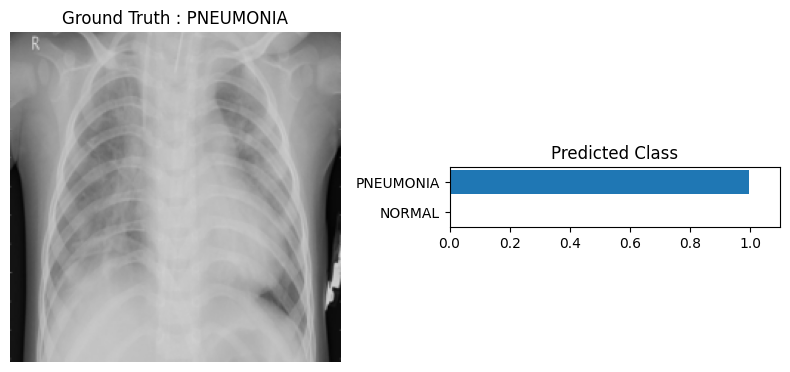

In [123]:
image,label = testset[241]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

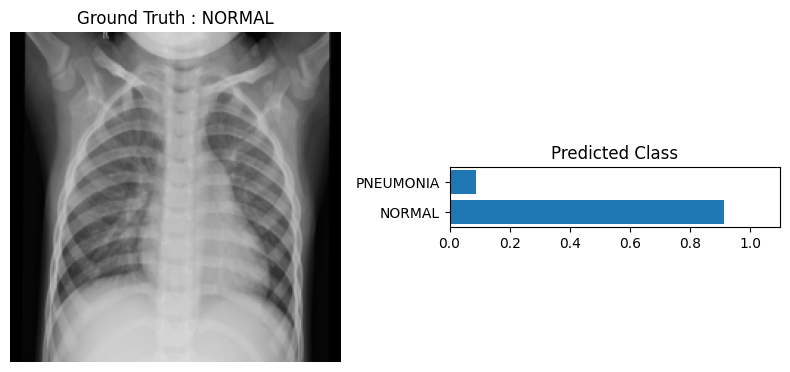

In [124]:
image,label = testset[108]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)